In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/Arra1807/Inform_project_new.git

fatal: destination path 'Inform_project_new' already exists and is not an empty directory.


In [ ]:
!nvidia-smi

Thu Jul 31 18:31:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P0             26W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Load Data

In [ ]:
import numpy as np
from Inform_project_new.data.echosounder_data.load_data.get_echograms_2 import get_echograms, count_classes_in_echograms

# You can select a specific year or use 'all' to include multiple years.
years = 2014
minimum_shape = 224
tuple_frequencies = (18, 38, 70, 120, 200, 333)
echograms = get_echograms(years=years, tuple_frequencies=tuple_frequencies, minimum_shape=minimum_shape)
print(f"Number of echograms: {len(echograms)}")


Number of echograms: 10


# Split Large Echograms into Train images and Test images

In [ ]:
Train_eg = []
test_eg = []
for i,echogram in enumerate(echograms):
  if i < 0.8*len(echograms) :
    Train_eg.append(echogram)
  else:
    test_eg.append(echogram)
print('Train Echogram:', len(Train_eg))
print('Test Echogram:', len(test_eg))

Train Echogram: 8
Test Echogram: 2


In [ ]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
import torch
import gc

# Manuell opprydding før trening
gc.collect()
torch.cuda.empty_cache()

# Sjekk og velg riktig device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Using device: cuda


In [ ]:
from Inform_project_new.data.echosounder_data.preprocessing.resize_and_crop import SplitResizeEchogram, generate_patch_batches
from Inform_project_new.data.echosounder_data.preprocessing.normalization import db, clip, standardize_min_max


data_transform = [db, clip, standardize_min_max]
split_patch_size = 224
output_patch_size = 224


#---Train set---
train_generators, num_patches_per_train_echogram = generate_patch_batches(Train_eg, split_patch_size,
                                                                          output_patch_size, data_transforms= data_transform,
                                                                          batch_size='full', verbose= False)
print('Number of patches per echogram for training:', num_patches_per_train_echogram )

#---Test set---
generators_test, num_patches_per_test_echogram = generate_patch_batches(test_eg, split_patch_size, output_patch_size,
                                                                        data_transforms= data_transform,
                                                                        batch_size='full', verbose= False)
print('Number of patches per echogram for testing:', num_patches_per_train_echogram )

Number of patches per echogram for training: [np.int64(35), np.int64(23), np.int64(21), np.int64(7), np.int64(59), np.int64(9), np.int64(23), np.int64(34)]
Number of patches per echogram for testing: [np.int64(35), np.int64(23), np.int64(21), np.int64(7), np.int64(59), np.int64(9), np.int64(23), np.int64(34)]


# Dataloader

In [ ]:
from Inform_project_new.data.echosounder_data.dataloader import BatchGeneratorDataset, GroupedGenerator, group_generators_by_patch_limit
from Inform_project_new.adaptation_method.model_config import Configuration
from torch.utils.data import DataLoader
import torch

#---Training set---
print('-------Dimensions for Training set-------------')
grouped_generator_fns, grouped_patch_count = group_generators_by_patch_limit(train_generators,
                                                                             num_patches_per_train_echogram,
                                                                             64)
run = Configuration()

train_dataset = BatchGeneratorDataset(grouped_generator_fns)
train_loader = DataLoader(train_dataset, batch_size = None, shuffle= False)

all_data_train = []
for labels, data, mask in train_loader:
  all_data_train.append(data)

data = torch.cat(all_data_train, dim=0)

B = run.config['batch_size']
train_batched_loader = torch.split(data, B, dim=0)
print('Number of batches:', len(train_batched_loader))
for batch in train_batched_loader:
  print(batch.shape)


-------Dimensions for Training set-------------


wandb: Currently logged in as: arangan18 (arangan18-university-of-oslo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Number of batches: 27
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([3, 6, 224, 224])


In [ ]:
#---Test Set---
print('-------Dimensions for Test set-------------')
grouped_generator_fns_test, grouped_patch_count_test = group_generators_by_patch_limit(generators_test,
                                                                                       num_patches_per_test_echogram,
                                                                                       100)
test_dataset = BatchGeneratorDataset(grouped_generator_fns_test)

test_loader = DataLoader(test_dataset, batch_size = None, shuffle= False)

all_data_test = []
for labels, data, mask in test_loader:
  all_data_test.append(data)

data = torch.cat(all_data_test, dim=0)

B = run.config['batch_size']
test_batched_loader = torch.split(data, B, dim=0)
print('Number of batches:', len(test_batched_loader))
for batch in test_batched_loader:
  print(batch.shape)


-------Dimensions for Test set-------------
Number of batches: 6
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([8, 6, 224, 224])
torch.Size([4, 6, 224, 224])


In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Thu Jul 31 18:51:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#from adaptation_method.train_autoencoder import train_val_encoder
from Inform_project_new.adaptation_method.train_autoencoder import train_val_encoder, plot_loss
from Inform_project_new.adaptation_method.Autoencoder import ResNetAutoEncoder
import torch.optim as optim
import torch.nn as nn

#For Logging
run = Configuration(model_name = 'ResNetAutoEncoder')

#Instantiating model
model = ResNetAutoEncoder()

# Defining Loss function and optimizer
Loss_func = nn.MSELoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr= run.config['learning_rate'],
                       weight_decay= run.config['Weight_decay']
)

encoded, avg_loss_train, val_encoded, avg_loss_val, epoch_stop = train_val_encoder(model, optimizer, Loss_func, run.config['epochs'], train_batched_loader, test_batched_loader, run)

plot_loss(run.config['epochs'], avg_loss_train, avg_loss_val, epoch_stop)

Epoch 1/50:   0%|          | 0/27 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 64.12 MiB is free. Process 362704 has 14.68 GiB memory in use. Of the allocated memory 14.54 GiB is allocated by PyTorch, and 19.34 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Epoch 1/200: 100%|██████████| 27/27 [00:01<00:00, 19.10it/s]


 Train Loss = 0.1010 ,Validation Loss = 0.0805
Saved new best model at epoch 1 with val_loss = 0.0805


Epoch 2/200: 100%|██████████| 27/27 [00:00<00:00, 32.01it/s]


 Train Loss = 0.0964 ,Validation Loss = 0.0771
Saved new best model at epoch 2 with val_loss = 0.0771


Epoch 3/200: 100%|██████████| 27/27 [00:00<00:00, 31.70it/s]


 Train Loss = 0.0923 ,Validation Loss = 0.0729
Saved new best model at epoch 3 with val_loss = 0.0729


Epoch 4/200: 100%|██████████| 27/27 [00:00<00:00, 31.81it/s]


 Train Loss = 0.0891 ,Validation Loss = 0.0709
Saved new best model at epoch 4 with val_loss = 0.0709


Epoch 5/200: 100%|██████████| 27/27 [00:00<00:00, 31.37it/s]


 Train Loss = 0.0850 ,Validation Loss = 0.0675
Saved new best model at epoch 5 with val_loss = 0.0675


Epoch 6/200: 100%|██████████| 27/27 [00:00<00:00, 31.15it/s]


 Train Loss = 0.0819 ,Validation Loss = 0.0635
Saved new best model at epoch 6 with val_loss = 0.0635


Epoch 7/200: 100%|██████████| 27/27 [00:00<00:00, 31.78it/s]


 Train Loss = 0.0789 ,Validation Loss = 0.0614
Saved new best model at epoch 7 with val_loss = 0.0614


Epoch 8/200: 100%|██████████| 27/27 [00:00<00:00, 31.86it/s]


 Train Loss = 0.0760 ,Validation Loss = 0.0576
Saved new best model at epoch 8 with val_loss = 0.0576


Epoch 9/200: 100%|██████████| 27/27 [00:00<00:00, 31.68it/s]


 Train Loss = 0.0730 ,Validation Loss = 0.0551
Saved new best model at epoch 9 with val_loss = 0.0551


Epoch 10/200: 100%|██████████| 27/27 [00:00<00:00, 31.75it/s]


 Train Loss = 0.0705 ,Validation Loss = 0.0534
Saved new best model at epoch 10 with val_loss = 0.0534


Epoch 11/200: 100%|██████████| 27/27 [00:00<00:00, 31.66it/s]


 Train Loss = 0.0684 ,Validation Loss = 0.0523
Saved new best model at epoch 11 with val_loss = 0.0523


Epoch 12/200: 100%|██████████| 27/27 [00:00<00:00, 31.52it/s]


 Train Loss = 0.0659 ,Validation Loss = 0.0497
Saved new best model at epoch 12 with val_loss = 0.0497


Epoch 13/200: 100%|██████████| 27/27 [00:00<00:00, 31.59it/s]


 Train Loss = 0.0643 ,Validation Loss = 0.0476
Saved new best model at epoch 13 with val_loss = 0.0476


Epoch 14/200: 100%|██████████| 27/27 [00:00<00:00, 31.52it/s]


 Train Loss = 0.0622 ,Validation Loss = 0.0463
Saved new best model at epoch 14 with val_loss = 0.0463


Epoch 15/200: 100%|██████████| 27/27 [00:00<00:00, 31.58it/s]


 Train Loss = 0.0603 ,Validation Loss = 0.0441
Saved new best model at epoch 15 with val_loss = 0.0441


Epoch 16/200: 100%|██████████| 27/27 [00:00<00:00, 31.55it/s]


 Train Loss = 0.0585 ,Validation Loss = 0.0431
Saved new best model at epoch 16 with val_loss = 0.0431


Epoch 17/200: 100%|██████████| 27/27 [00:00<00:00, 31.34it/s]


 Train Loss = 0.0572 ,Validation Loss = 0.0425
Saved new best model at epoch 17 with val_loss = 0.0425


Epoch 18/200: 100%|██████████| 27/27 [00:00<00:00, 30.98it/s]


 Train Loss = 0.0558 ,Validation Loss = 0.0411
Saved new best model at epoch 18 with val_loss = 0.0411


Epoch 19/200: 100%|██████████| 27/27 [00:00<00:00, 30.95it/s]


 Train Loss = 0.0541 ,Validation Loss = 0.0402
Saved new best model at epoch 19 with val_loss = 0.0402


Epoch 20/200: 100%|██████████| 27/27 [00:00<00:00, 31.04it/s]


 Train Loss = 0.0531 ,Validation Loss = 0.0390
Saved new best model at epoch 20 with val_loss = 0.0390


Epoch 21/200: 100%|██████████| 27/27 [00:00<00:00, 30.85it/s]


 Train Loss = 0.0516 ,Validation Loss = 0.0381
Saved new best model at epoch 21 with val_loss = 0.0381


Epoch 22/200: 100%|██████████| 27/27 [00:00<00:00, 31.26it/s]


 Train Loss = 0.0502 ,Validation Loss = 0.0368
Saved new best model at epoch 22 with val_loss = 0.0368


Epoch 23/200: 100%|██████████| 27/27 [00:00<00:00, 31.31it/s]


 Train Loss = 0.0493 ,Validation Loss = 0.0361
Saved new best model at epoch 23 with val_loss = 0.0361


Epoch 24/200: 100%|██████████| 27/27 [00:00<00:00, 31.21it/s]


 Train Loss = 0.0480 ,Validation Loss = 0.0351
Saved new best model at epoch 24 with val_loss = 0.0351


Epoch 25/200: 100%|██████████| 27/27 [00:00<00:00, 31.25it/s]


 Train Loss = 0.0468 ,Validation Loss = 0.0347
Saved new best model at epoch 25 with val_loss = 0.0347


Epoch 26/200: 100%|██████████| 27/27 [00:00<00:00, 31.33it/s]


 Train Loss = 0.0457 ,Validation Loss = 0.0336
Saved new best model at epoch 26 with val_loss = 0.0336


Epoch 27/200: 100%|██████████| 27/27 [00:00<00:00, 31.33it/s]


 Train Loss = 0.0448 ,Validation Loss = 0.0330
Saved new best model at epoch 27 with val_loss = 0.0330


Epoch 28/200: 100%|██████████| 27/27 [00:00<00:00, 31.43it/s]


 Train Loss = 0.0440 ,Validation Loss = 0.0329
Saved new best model at epoch 28 with val_loss = 0.0329


Epoch 29/200: 100%|██████████| 27/27 [00:00<00:00, 31.33it/s]


 Train Loss = 0.0433 ,Validation Loss = 0.0315
Saved new best model at epoch 29 with val_loss = 0.0315


Epoch 30/200: 100%|██████████| 27/27 [00:00<00:00, 31.31it/s]


 Train Loss = 0.0422 ,Validation Loss = 0.0314
Saved new best model at epoch 30 with val_loss = 0.0314


Epoch 31/200: 100%|██████████| 27/27 [00:00<00:00, 31.29it/s]


 Train Loss = 0.0414 ,Validation Loss = 0.0305
Saved new best model at epoch 31 with val_loss = 0.0305


Epoch 32/200: 100%|██████████| 27/27 [00:00<00:00, 31.34it/s]


 Train Loss = 0.0407 ,Validation Loss = 0.0301
Saved new best model at epoch 32 with val_loss = 0.0301


Epoch 33/200: 100%|██████████| 27/27 [00:00<00:00, 31.18it/s]


 Train Loss = 0.0398 ,Validation Loss = 0.0294
Saved new best model at epoch 33 with val_loss = 0.0294


Epoch 34/200: 100%|██████████| 27/27 [00:00<00:00, 31.10it/s]


 Train Loss = 0.0391 ,Validation Loss = 0.0289
Saved new best model at epoch 34 with val_loss = 0.0289


Epoch 35/200: 100%|██████████| 27/27 [00:00<00:00, 31.34it/s]


 Train Loss = 0.0385 ,Validation Loss = 0.0286
Saved new best model at epoch 35 with val_loss = 0.0286


Epoch 36/200: 100%|██████████| 27/27 [00:00<00:00, 31.29it/s]


 Train Loss = 0.0377 ,Validation Loss = 0.0276
Saved new best model at epoch 36 with val_loss = 0.0276


Epoch 37/200: 100%|██████████| 27/27 [00:00<00:00, 31.69it/s]


 Train Loss = 0.0370 ,Validation Loss = 0.0276
Saved new best model at epoch 37 with val_loss = 0.0276


Epoch 38/200: 100%|██████████| 27/27 [00:00<00:00, 31.78it/s]


 Train Loss = 0.0363 ,Validation Loss = 0.0267
Saved new best model at epoch 38 with val_loss = 0.0267


Epoch 39/200: 100%|██████████| 27/27 [00:00<00:00, 31.69it/s]


 Train Loss = 0.0358 ,Validation Loss = 0.0265
Saved new best model at epoch 39 with val_loss = 0.0265


Epoch 40/200: 100%|██████████| 27/27 [00:00<00:00, 31.73it/s]


 Train Loss = 0.0353 ,Validation Loss = 0.0258
Saved new best model at epoch 40 with val_loss = 0.0258


Epoch 41/200: 100%|██████████| 27/27 [00:00<00:00, 31.77it/s]


 Train Loss = 0.0349 ,Validation Loss = 0.0261


Epoch 42/200: 100%|██████████| 27/27 [00:00<00:00, 31.68it/s]


 Train Loss = 0.0345 ,Validation Loss = 0.0253
Saved new best model at epoch 42 with val_loss = 0.0253


Epoch 43/200: 100%|██████████| 27/27 [00:00<00:00, 31.61it/s]


 Train Loss = 0.0338 ,Validation Loss = 0.0250
Saved new best model at epoch 43 with val_loss = 0.0250


Epoch 44/200: 100%|██████████| 27/27 [00:00<00:00, 31.06it/s]


 Train Loss = 0.0332 ,Validation Loss = 0.0244
Saved new best model at epoch 44 with val_loss = 0.0244


Epoch 45/200: 100%|██████████| 27/27 [00:00<00:00, 31.79it/s]


 Train Loss = 0.0326 ,Validation Loss = 0.0245


Epoch 46/200: 100%|██████████| 27/27 [00:00<00:00, 31.57it/s]


 Train Loss = 0.0323 ,Validation Loss = 0.0240
Saved new best model at epoch 46 with val_loss = 0.0240


Epoch 47/200: 100%|██████████| 27/27 [00:00<00:00, 31.89it/s]


 Train Loss = 0.0318 ,Validation Loss = 0.0240
Saved new best model at epoch 47 with val_loss = 0.0240


Epoch 48/200: 100%|██████████| 27/27 [00:00<00:00, 31.61it/s]


 Train Loss = 0.0311 ,Validation Loss = 0.0238
Saved new best model at epoch 48 with val_loss = 0.0238


Epoch 49/200: 100%|██████████| 27/27 [00:00<00:00, 31.57it/s]


 Train Loss = 0.0311 ,Validation Loss = 0.0233
Saved new best model at epoch 49 with val_loss = 0.0233


Epoch 50/200: 100%|██████████| 27/27 [00:00<00:00, 31.46it/s]


 Train Loss = 0.0305 ,Validation Loss = 0.0236


Epoch 51/200: 100%|██████████| 27/27 [00:00<00:00, 31.81it/s]


 Train Loss = 0.0303 ,Validation Loss = 0.0232
Saved new best model at epoch 51 with val_loss = 0.0232


Epoch 52/200: 100%|██████████| 27/27 [00:00<00:00, 31.88it/s]


 Train Loss = 0.0300 ,Validation Loss = 0.0230
Saved new best model at epoch 52 with val_loss = 0.0230


Epoch 53/200: 100%|██████████| 27/27 [00:00<00:00, 31.93it/s]


 Train Loss = 0.0297 ,Validation Loss = 0.0229
Saved new best model at epoch 53 with val_loss = 0.0229


Epoch 54/200: 100%|██████████| 27/27 [00:00<00:00, 31.88it/s]


 Train Loss = 0.0292 ,Validation Loss = 0.0225
Saved new best model at epoch 54 with val_loss = 0.0225


Epoch 55/200: 100%|██████████| 27/27 [00:00<00:00, 32.15it/s]


 Train Loss = 0.0294 ,Validation Loss = 0.0228


Epoch 56/200: 100%|██████████| 27/27 [00:00<00:00, 32.04it/s]


 Train Loss = 0.0285 ,Validation Loss = 0.0219
Saved new best model at epoch 56 with val_loss = 0.0219


Epoch 57/200: 100%|██████████| 27/27 [00:00<00:00, 32.08it/s]


 Train Loss = 0.0283 ,Validation Loss = 0.0214
Saved new best model at epoch 57 with val_loss = 0.0214


Epoch 58/200: 100%|██████████| 27/27 [00:00<00:00, 32.05it/s]


 Train Loss = 0.0282 ,Validation Loss = 0.0225


Epoch 59/200: 100%|██████████| 27/27 [00:00<00:00, 32.11it/s]


 Train Loss = 0.0278 ,Validation Loss = 0.0222


Epoch 60/200: 100%|██████████| 27/27 [00:00<00:00, 32.29it/s]


 Train Loss = 0.0274 ,Validation Loss = 0.0210
Saved new best model at epoch 60 with val_loss = 0.0210


Epoch 61/200: 100%|██████████| 27/27 [00:00<00:00, 32.12it/s]


 Train Loss = 0.0276 ,Validation Loss = 0.0213


Epoch 62/200: 100%|██████████| 27/27 [00:00<00:00, 31.81it/s]


 Train Loss = 0.0270 ,Validation Loss = 0.0217


Epoch 63/200: 100%|██████████| 27/27 [00:00<00:00, 30.77it/s]


 Train Loss = 0.0265 ,Validation Loss = 0.0213
Stopping early at epoch 63


Epoch 64/200: 100%|██████████| 27/27 [00:00<00:00, 31.13it/s]


 Train Loss = 0.0267 ,Validation Loss = 0.0206
Saved new best model at epoch 64 with val_loss = 0.0206


Epoch 65/200: 100%|██████████| 27/27 [00:00<00:00, 30.83it/s]


 Train Loss = 0.0266 ,Validation Loss = 0.0207


Epoch 66/200: 100%|██████████| 27/27 [00:00<00:00, 31.64it/s]


 Train Loss = 0.0262 ,Validation Loss = 0.0210


Epoch 67/200: 100%|██████████| 27/27 [00:00<00:00, 31.97it/s]


 Train Loss = 0.0256 ,Validation Loss = 0.0207


Epoch 68/200: 100%|██████████| 27/27 [00:00<00:00, 31.77it/s]


 Train Loss = 0.0252 ,Validation Loss = 0.0207


Epoch 69/200: 100%|██████████| 27/27 [00:00<00:00, 32.04it/s]


 Train Loss = 0.0251 ,Validation Loss = 0.0202
Saved new best model at epoch 69 with val_loss = 0.0202


Epoch 70/200: 100%|██████████| 27/27 [00:00<00:00, 32.02it/s]


 Train Loss = 0.0244 ,Validation Loss = 0.0206


Epoch 71/200: 100%|██████████| 27/27 [00:00<00:00, 31.92it/s]


 Train Loss = 0.0244 ,Validation Loss = 0.0196
Saved new best model at epoch 71 with val_loss = 0.0196


Epoch 72/200: 100%|██████████| 27/27 [00:00<00:00, 31.90it/s]


 Train Loss = 0.0245 ,Validation Loss = 0.0199


Epoch 73/200: 100%|██████████| 27/27 [00:00<00:00, 32.01it/s]


 Train Loss = 0.0245 ,Validation Loss = 0.0188
Saved new best model at epoch 73 with val_loss = 0.0188


Epoch 74/200: 100%|██████████| 27/27 [00:00<00:00, 32.14it/s]


 Train Loss = 0.0240 ,Validation Loss = 0.0192


Epoch 75/200: 100%|██████████| 27/27 [00:00<00:00, 32.22it/s]


 Train Loss = 0.0238 ,Validation Loss = 0.0191


Epoch 76/200: 100%|██████████| 27/27 [00:00<00:00, 31.96it/s]


 Train Loss = 0.0238 ,Validation Loss = 0.0195


Epoch 77/200: 100%|██████████| 27/27 [00:00<00:00, 32.23it/s]


 Train Loss = 0.0233 ,Validation Loss = 0.0196


Epoch 78/200: 100%|██████████| 27/27 [00:00<00:00, 31.34it/s]


 Train Loss = 0.0231 ,Validation Loss = 0.0201


Epoch 79/200: 100%|██████████| 27/27 [00:00<00:00, 31.85it/s]


 Train Loss = 0.0234 ,Validation Loss = 0.0193


Epoch 80/200: 100%|██████████| 27/27 [00:00<00:00, 31.74it/s]


 Train Loss = 0.0228 ,Validation Loss = 0.0182
Saved new best model at epoch 80 with val_loss = 0.0182


Epoch 81/200: 100%|██████████| 27/27 [00:00<00:00, 31.38it/s]


 Train Loss = 0.0225 ,Validation Loss = 0.0184


Epoch 82/200: 100%|██████████| 27/27 [00:00<00:00, 31.72it/s]


 Train Loss = 0.0230 ,Validation Loss = 0.0186


Epoch 83/200: 100%|██████████| 27/27 [00:00<00:00, 32.13it/s]


 Train Loss = 0.0218 ,Validation Loss = 0.0177
Saved new best model at epoch 83 with val_loss = 0.0177


Epoch 84/200: 100%|██████████| 27/27 [00:00<00:00, 32.14it/s]


 Train Loss = 0.0214 ,Validation Loss = 0.0178


Epoch 85/200: 100%|██████████| 27/27 [00:00<00:00, 32.19it/s]


 Train Loss = 0.0218 ,Validation Loss = 0.0181


Epoch 86/200: 100%|██████████| 27/27 [00:00<00:00, 32.41it/s]


 Train Loss = 0.0215 ,Validation Loss = 0.0181


Epoch 87/200: 100%|██████████| 27/27 [00:00<00:00, 32.18it/s]


 Train Loss = 0.0210 ,Validation Loss = 0.0187


Epoch 88/200: 100%|██████████| 27/27 [00:00<00:00, 32.05it/s]


 Train Loss = 0.0208 ,Validation Loss = 0.0180


Epoch 89/200: 100%|██████████| 27/27 [00:00<00:00, 32.12it/s]


 Train Loss = 0.0205 ,Validation Loss = 0.0167
Saved new best model at epoch 89 with val_loss = 0.0167


Epoch 90/200: 100%|██████████| 27/27 [00:00<00:00, 31.84it/s]


 Train Loss = 0.0205 ,Validation Loss = 0.0179


Epoch 91/200: 100%|██████████| 27/27 [00:00<00:00, 32.14it/s]


 Train Loss = 0.0199 ,Validation Loss = 0.0162
Saved new best model at epoch 91 with val_loss = 0.0162


Epoch 92/200: 100%|██████████| 27/27 [00:00<00:00, 32.00it/s]


 Train Loss = 0.0197 ,Validation Loss = 0.0176


Epoch 93/200: 100%|██████████| 27/27 [00:00<00:00, 31.91it/s]


 Train Loss = 0.0197 ,Validation Loss = 0.0173


Epoch 94/200: 100%|██████████| 27/27 [00:00<00:00, 31.20it/s]


 Train Loss = 0.0197 ,Validation Loss = 0.0169


Epoch 95/200: 100%|██████████| 27/27 [00:00<00:00, 31.18it/s]


 Train Loss = 0.0191 ,Validation Loss = 0.0161
Saved new best model at epoch 95 with val_loss = 0.0161


Epoch 96/200: 100%|██████████| 27/27 [00:00<00:00, 31.29it/s]


 Train Loss = 0.0187 ,Validation Loss = 0.0171


Epoch 97/200: 100%|██████████| 27/27 [00:00<00:00, 31.77it/s]


 Train Loss = 0.0181 ,Validation Loss = 0.0163


Epoch 98/200: 100%|██████████| 27/27 [00:00<00:00, 32.05it/s]


 Train Loss = 0.0180 ,Validation Loss = 0.0155
Saved new best model at epoch 98 with val_loss = 0.0155


Epoch 99/200: 100%|██████████| 27/27 [00:00<00:00, 31.83it/s]


 Train Loss = 0.0175 ,Validation Loss = 0.0154
Saved new best model at epoch 99 with val_loss = 0.0154


Epoch 100/200: 100%|██████████| 27/27 [00:00<00:00, 31.88it/s]


 Train Loss = 0.0176 ,Validation Loss = 0.0160


Epoch 101/200: 100%|██████████| 27/27 [00:00<00:00, 31.91it/s]


 Train Loss = 0.0178 ,Validation Loss = 0.0155


Epoch 102/200: 100%|██████████| 27/27 [00:00<00:00, 31.86it/s]


 Train Loss = 0.0170 ,Validation Loss = 0.0163


Epoch 103/200: 100%|██████████| 27/27 [00:00<00:00, 31.81it/s]


 Train Loss = 0.0162 ,Validation Loss = 0.0151
Saved new best model at epoch 103 with val_loss = 0.0151


Epoch 104/200: 100%|██████████| 27/27 [00:00<00:00, 31.90it/s]


 Train Loss = 0.0160 ,Validation Loss = 0.0149
Saved new best model at epoch 104 with val_loss = 0.0149


Epoch 105/200: 100%|██████████| 27/27 [00:00<00:00, 31.79it/s]


 Train Loss = 0.0160 ,Validation Loss = 0.0149
Saved new best model at epoch 105 with val_loss = 0.0149


Epoch 106/200: 100%|██████████| 27/27 [00:00<00:00, 31.99it/s]


 Train Loss = 0.0152 ,Validation Loss = 0.0141
Saved new best model at epoch 106 with val_loss = 0.0141


Epoch 107/200: 100%|██████████| 27/27 [00:00<00:00, 32.11it/s]


 Train Loss = 0.0152 ,Validation Loss = 0.0143


Epoch 108/200: 100%|██████████| 27/27 [00:00<00:00, 31.30it/s]


 Train Loss = 0.0151 ,Validation Loss = 0.0146


Epoch 109/200: 100%|██████████| 27/27 [00:00<00:00, 31.41it/s]


 Train Loss = 0.0155 ,Validation Loss = 0.0135
Saved new best model at epoch 109 with val_loss = 0.0135


Epoch 110/200: 100%|██████████| 27/27 [00:00<00:00, 31.62it/s]


 Train Loss = 0.0159 ,Validation Loss = 0.0136


Epoch 111/200: 100%|██████████| 27/27 [00:00<00:00, 31.38it/s]


 Train Loss = 0.0146 ,Validation Loss = 0.0137


Epoch 112/200: 100%|██████████| 27/27 [00:00<00:00, 31.71it/s]


 Train Loss = 0.0143 ,Validation Loss = 0.0145


Epoch 113/200: 100%|██████████| 27/27 [00:00<00:00, 31.86it/s]


 Train Loss = 0.0152 ,Validation Loss = 0.0145


Epoch 114/200: 100%|██████████| 27/27 [00:00<00:00, 31.92it/s]


 Train Loss = 0.0140 ,Validation Loss = 0.0140


Epoch 115/200: 100%|██████████| 27/27 [00:00<00:00, 31.88it/s]


 Train Loss = 0.0142 ,Validation Loss = 0.0133
Saved new best model at epoch 115 with val_loss = 0.0133


Epoch 116/200: 100%|██████████| 27/27 [00:00<00:00, 31.84it/s]


 Train Loss = 0.0138 ,Validation Loss = 0.0141


Epoch 117/200: 100%|██████████| 27/27 [00:00<00:00, 31.86it/s]


 Train Loss = 0.0129 ,Validation Loss = 0.0130
Saved new best model at epoch 117 with val_loss = 0.0130


Epoch 118/200: 100%|██████████| 27/27 [00:00<00:00, 31.38it/s]


 Train Loss = 0.0140 ,Validation Loss = 0.0130


Epoch 119/200: 100%|██████████| 27/27 [00:00<00:00, 31.15it/s]


 Train Loss = 0.0130 ,Validation Loss = 0.0142


Epoch 120/200: 100%|██████████| 27/27 [00:00<00:00, 30.94it/s]


 Train Loss = 0.0133 ,Validation Loss = 0.0144


Epoch 121/200: 100%|██████████| 27/27 [00:00<00:00, 30.58it/s]


 Train Loss = 0.0129 ,Validation Loss = 0.0129
Saved new best model at epoch 121 with val_loss = 0.0129


Epoch 122/200: 100%|██████████| 27/27 [00:00<00:00, 31.43it/s]


 Train Loss = 0.0133 ,Validation Loss = 0.0141


Epoch 123/200: 100%|██████████| 27/27 [00:00<00:00, 31.30it/s]


 Train Loss = 0.0131 ,Validation Loss = 0.0132


Epoch 124/200: 100%|██████████| 27/27 [00:00<00:00, 31.27it/s]


 Train Loss = 0.0128 ,Validation Loss = 0.0136


Epoch 125/200: 100%|██████████| 27/27 [00:00<00:00, 31.18it/s]


 Train Loss = 0.0129 ,Validation Loss = 0.0126
Saved new best model at epoch 125 with val_loss = 0.0126


Epoch 126/200: 100%|██████████| 27/27 [00:00<00:00, 31.31it/s]


 Train Loss = 0.0124 ,Validation Loss = 0.0128


Epoch 127/200: 100%|██████████| 27/27 [00:00<00:00, 31.19it/s]


 Train Loss = 0.0122 ,Validation Loss = 0.0126
Saved new best model at epoch 127 with val_loss = 0.0126


Epoch 128/200: 100%|██████████| 27/27 [00:00<00:00, 31.88it/s]


 Train Loss = 0.0120 ,Validation Loss = 0.0127


Epoch 129/200: 100%|██████████| 27/27 [00:00<00:00, 31.73it/s]


 Train Loss = 0.0121 ,Validation Loss = 0.0124
Saved new best model at epoch 129 with val_loss = 0.0124


Epoch 130/200: 100%|██████████| 27/27 [00:00<00:00, 31.81it/s]


 Train Loss = 0.0119 ,Validation Loss = 0.0127


Epoch 131/200: 100%|██████████| 27/27 [00:00<00:00, 31.73it/s]


 Train Loss = 0.0119 ,Validation Loss = 0.0121
Saved new best model at epoch 131 with val_loss = 0.0121


Epoch 132/200: 100%|██████████| 27/27 [00:00<00:00, 31.82it/s]


 Train Loss = 0.0119 ,Validation Loss = 0.0129


Epoch 133/200: 100%|██████████| 27/27 [00:00<00:00, 31.87it/s]


 Train Loss = 0.0116 ,Validation Loss = 0.0123


Epoch 134/200: 100%|██████████| 27/27 [00:00<00:00, 31.89it/s]


 Train Loss = 0.0113 ,Validation Loss = 0.0122


Epoch 135/200: 100%|██████████| 27/27 [00:00<00:00, 31.87it/s]


 Train Loss = 0.0116 ,Validation Loss = 0.0124


Epoch 136/200: 100%|██████████| 27/27 [00:00<00:00, 31.78it/s]


 Train Loss = 0.0110 ,Validation Loss = 0.0121


Epoch 137/200: 100%|██████████| 27/27 [00:00<00:00, 31.76it/s]


 Train Loss = 0.0114 ,Validation Loss = 0.0124


Epoch 138/200: 100%|██████████| 27/27 [00:00<00:00, 31.49it/s]


 Train Loss = 0.0110 ,Validation Loss = 0.0128


Epoch 139/200: 100%|██████████| 27/27 [00:00<00:00, 30.95it/s]


 Train Loss = 0.0109 ,Validation Loss = 0.0121


Epoch 140/200: 100%|██████████| 27/27 [00:00<00:00, 30.86it/s]


 Train Loss = 0.0109 ,Validation Loss = 0.0122


Epoch 141/200: 100%|██████████| 27/27 [00:00<00:00, 31.07it/s]


 Train Loss = 0.0110 ,Validation Loss = 0.0123


Epoch 142/200: 100%|██████████| 27/27 [00:00<00:00, 31.63it/s]


 Train Loss = 0.0109 ,Validation Loss = 0.0119
Saved new best model at epoch 142 with val_loss = 0.0119


Epoch 143/200: 100%|██████████| 27/27 [00:00<00:00, 31.96it/s]


 Train Loss = 0.0109 ,Validation Loss = 0.0121


Epoch 144/200: 100%|██████████| 27/27 [00:00<00:00, 31.79it/s]


 Train Loss = 0.0108 ,Validation Loss = 0.0119


Epoch 145/200: 100%|██████████| 27/27 [00:00<00:00, 31.80it/s]


 Train Loss = 0.0106 ,Validation Loss = 0.0118
Saved new best model at epoch 145 with val_loss = 0.0118


Epoch 146/200: 100%|██████████| 27/27 [00:00<00:00, 31.79it/s]


 Train Loss = 0.0105 ,Validation Loss = 0.0117
Saved new best model at epoch 146 with val_loss = 0.0117


Epoch 147/200: 100%|██████████| 27/27 [00:00<00:00, 31.90it/s]


 Train Loss = 0.0104 ,Validation Loss = 0.0119


Epoch 148/200: 100%|██████████| 27/27 [00:00<00:00, 32.00it/s]


 Train Loss = 0.0105 ,Validation Loss = 0.0120


Epoch 149/200: 100%|██████████| 27/27 [00:00<00:00, 32.02it/s]


 Train Loss = 0.0104 ,Validation Loss = 0.0116
Saved new best model at epoch 149 with val_loss = 0.0116


Epoch 150/200: 100%|██████████| 27/27 [00:00<00:00, 31.99it/s]


 Train Loss = 0.0103 ,Validation Loss = 0.0113
Saved new best model at epoch 150 with val_loss = 0.0113


Epoch 151/200: 100%|██████████| 27/27 [00:00<00:00, 31.89it/s]


 Train Loss = 0.0103 ,Validation Loss = 0.0115


Epoch 152/200: 100%|██████████| 27/27 [00:00<00:00, 31.53it/s]


 Train Loss = 0.0102 ,Validation Loss = 0.0116


Epoch 153/200: 100%|██████████| 27/27 [00:00<00:00, 31.51it/s]


 Train Loss = 0.0101 ,Validation Loss = 0.0118


Epoch 154/200: 100%|██████████| 27/27 [00:00<00:00, 31.07it/s]


 Train Loss = 0.0102 ,Validation Loss = 0.0117


Epoch 155/200: 100%|██████████| 27/27 [00:00<00:00, 31.45it/s]


 Train Loss = 0.0099 ,Validation Loss = 0.0121


Epoch 156/200: 100%|██████████| 27/27 [00:00<00:00, 31.72it/s]


 Train Loss = 0.0100 ,Validation Loss = 0.0115


Epoch 157/200: 100%|██████████| 27/27 [00:00<00:00, 31.80it/s]


 Train Loss = 0.0097 ,Validation Loss = 0.0120


Epoch 158/200: 100%|██████████| 27/27 [00:00<00:00, 31.56it/s]


 Train Loss = 0.0097 ,Validation Loss = 0.0113


Epoch 159/200: 100%|██████████| 27/27 [00:00<00:00, 32.10it/s]


 Train Loss = 0.0098 ,Validation Loss = 0.0111
Saved new best model at epoch 159 with val_loss = 0.0111


Epoch 160/200: 100%|██████████| 27/27 [00:00<00:00, 32.11it/s]


 Train Loss = 0.0097 ,Validation Loss = 0.0110
Saved new best model at epoch 160 with val_loss = 0.0110


Epoch 161/200: 100%|██████████| 27/27 [00:00<00:00, 32.07it/s]


 Train Loss = 0.0096 ,Validation Loss = 0.0113


Epoch 162/200: 100%|██████████| 27/27 [00:00<00:00, 32.14it/s]


 Train Loss = 0.0098 ,Validation Loss = 0.0119


Epoch 163/200: 100%|██████████| 27/27 [00:00<00:00, 32.02it/s]


 Train Loss = 0.0097 ,Validation Loss = 0.0117


Epoch 164/200: 100%|██████████| 27/27 [00:00<00:00, 32.05it/s]


 Train Loss = 0.0096 ,Validation Loss = 0.0112


Epoch 165/200: 100%|██████████| 27/27 [00:00<00:00, 32.05it/s]


 Train Loss = 0.0093 ,Validation Loss = 0.0116


Epoch 166/200: 100%|██████████| 27/27 [00:00<00:00, 31.96it/s]


 Train Loss = 0.0094 ,Validation Loss = 0.0113


Epoch 167/200: 100%|██████████| 27/27 [00:00<00:00, 32.14it/s]


 Train Loss = 0.0097 ,Validation Loss = 0.0110
Saved new best model at epoch 167 with val_loss = 0.0110


Epoch 168/200: 100%|██████████| 27/27 [00:00<00:00, 32.02it/s]


 Train Loss = 0.0096 ,Validation Loss = 0.0117


Epoch 169/200: 100%|██████████| 27/27 [00:00<00:00, 31.71it/s]


 Train Loss = 0.0094 ,Validation Loss = 0.0116


Epoch 170/200: 100%|██████████| 27/27 [00:00<00:00, 31.14it/s]


 Train Loss = 0.0093 ,Validation Loss = 0.0111


Epoch 171/200: 100%|██████████| 27/27 [00:00<00:00, 31.30it/s]


 Train Loss = 0.0093 ,Validation Loss = 0.0115


Epoch 172/200: 100%|██████████| 27/27 [00:00<00:00, 31.74it/s]


 Train Loss = 0.0093 ,Validation Loss = 0.0112


Epoch 173/200: 100%|██████████| 27/27 [00:00<00:00, 32.11it/s]


 Train Loss = 0.0093 ,Validation Loss = 0.0111


Epoch 174/200: 100%|██████████| 27/27 [00:00<00:00, 32.12it/s]


 Train Loss = 0.0092 ,Validation Loss = 0.0108
Saved new best model at epoch 174 with val_loss = 0.0108


Epoch 175/200: 100%|██████████| 27/27 [00:00<00:00, 32.12it/s]


 Train Loss = 0.0090 ,Validation Loss = 0.0109


Epoch 176/200: 100%|██████████| 27/27 [00:00<00:00, 32.05it/s]


 Train Loss = 0.0092 ,Validation Loss = 0.0111


Epoch 177/200: 100%|██████████| 27/27 [00:00<00:00, 32.13it/s]


 Train Loss = 0.0091 ,Validation Loss = 0.0112


Epoch 178/200: 100%|██████████| 27/27 [00:00<00:00, 32.02it/s]


 Train Loss = 0.0090 ,Validation Loss = 0.0109


Epoch 179/200: 100%|██████████| 27/27 [00:00<00:00, 32.02it/s]


 Train Loss = 0.0092 ,Validation Loss = 0.0117


Epoch 180/200: 100%|██████████| 27/27 [00:00<00:00, 32.05it/s]


 Train Loss = 0.0088 ,Validation Loss = 0.0107
Saved new best model at epoch 180 with val_loss = 0.0107


Epoch 181/200: 100%|██████████| 27/27 [00:00<00:00, 32.21it/s]


 Train Loss = 0.0089 ,Validation Loss = 0.0110


Epoch 182/200: 100%|██████████| 27/27 [00:00<00:00, 32.12it/s]


 Train Loss = 0.0089 ,Validation Loss = 0.0110


Epoch 183/200: 100%|██████████| 27/27 [00:00<00:00, 31.88it/s]


 Train Loss = 0.0087 ,Validation Loss = 0.0109


Epoch 184/200: 100%|██████████| 27/27 [00:00<00:00, 30.35it/s]


 Train Loss = 0.0088 ,Validation Loss = 0.0107
Saved new best model at epoch 184 with val_loss = 0.0107


Epoch 185/200: 100%|██████████| 27/27 [00:00<00:00, 28.64it/s]


 Train Loss = 0.0089 ,Validation Loss = 0.0107


Epoch 186/200: 100%|██████████| 27/27 [00:00<00:00, 30.51it/s]


 Train Loss = 0.0088 ,Validation Loss = 0.0108


Epoch 187/200: 100%|██████████| 27/27 [00:00<00:00, 31.47it/s]


 Train Loss = 0.0089 ,Validation Loss = 0.0108


Epoch 188/200: 100%|██████████| 27/27 [00:00<00:00, 31.96it/s]


 Train Loss = 0.0088 ,Validation Loss = 0.0106
Saved new best model at epoch 188 with val_loss = 0.0106


Epoch 189/200: 100%|██████████| 27/27 [00:00<00:00, 32.09it/s]


 Train Loss = 0.0087 ,Validation Loss = 0.0107


Epoch 190/200: 100%|██████████| 27/27 [00:00<00:00, 32.15it/s]


 Train Loss = 0.0087 ,Validation Loss = 0.0104
Saved new best model at epoch 190 with val_loss = 0.0104


Epoch 191/200: 100%|██████████| 27/27 [00:00<00:00, 32.03it/s]


 Train Loss = 0.0086 ,Validation Loss = 0.0109


Epoch 192/200: 100%|██████████| 27/27 [00:00<00:00, 31.94it/s]


 Train Loss = 0.0087 ,Validation Loss = 0.0105


Epoch 193/200: 100%|██████████| 27/27 [00:00<00:00, 32.08it/s]


 Train Loss = 0.0088 ,Validation Loss = 0.0107


Epoch 194/200: 100%|██████████| 27/27 [00:00<00:00, 31.88it/s]


 Train Loss = 0.0085 ,Validation Loss = 0.0106


Epoch 195/200: 100%|██████████| 27/27 [00:00<00:00, 32.08it/s]


 Train Loss = 0.0085 ,Validation Loss = 0.0108


Epoch 196/200: 100%|██████████| 27/27 [00:00<00:00, 32.04it/s]


 Train Loss = 0.0086 ,Validation Loss = 0.0106


Epoch 197/200: 100%|██████████| 27/27 [00:00<00:00, 32.01it/s]


 Train Loss = 0.0085 ,Validation Loss = 0.0109


Epoch 198/200: 100%|██████████| 27/27 [00:00<00:00, 32.22it/s]


 Train Loss = 0.0084 ,Validation Loss = 0.0106


Epoch 199/200: 100%|██████████| 27/27 [00:00<00:00, 31.44it/s]


 Train Loss = 0.0084 ,Validation Loss = 0.0104


Epoch 200/200: 100%|██████████| 27/27 [00:00<00:00, 31.43it/s]


 Train Loss = 0.0084 ,Validation Loss = 0.0104


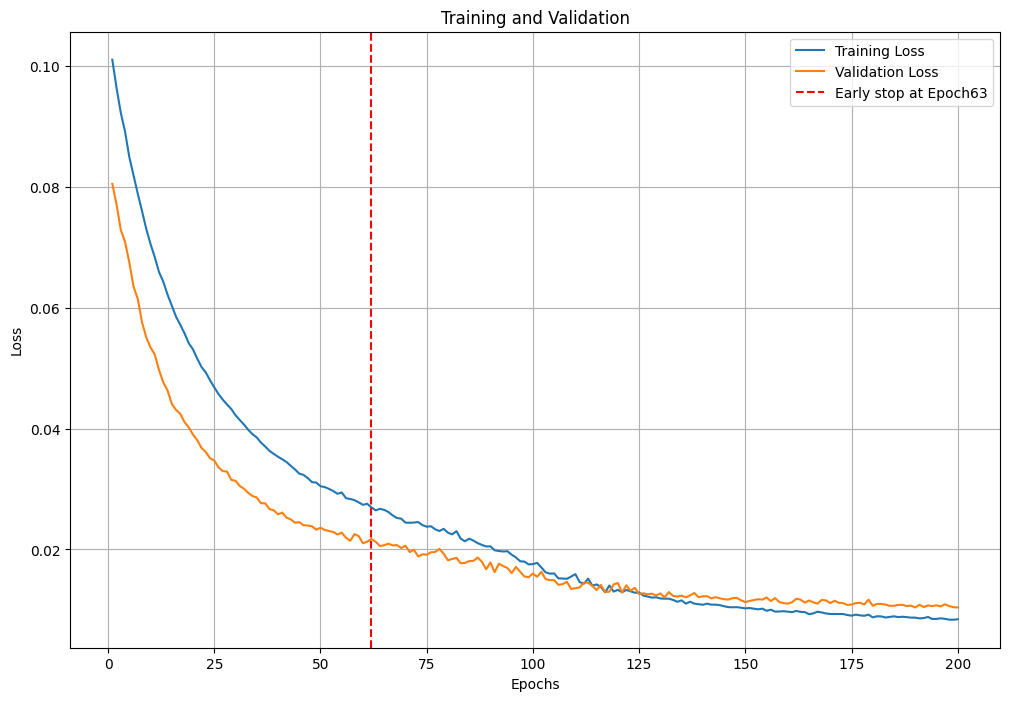

In [ ]:
from Inform_project_new.adaptation_method.train_autoencoder import train_val_encoder, plot_loss
from Inform_project_new.adaptation_method.Autoencoder import Autoencoder
import torch.nn as nn
import torch.optim as optim

#For logging
run = Configuration(model_name = 'Autoencoder')

#Instantiating model
model = Autoencoder()



# Defining Loss function and optimizer
Loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = run.config['learning_rate'], weight_decay = run.config['Weight_decay'])

latent, avg_loss_train, val_latent, avg_loss_val, stop_epoch = train_val_encoder(model, optimizer, Loss_func, run.config['epochs'], train_batched_loader, test_batched_loader, run)

plot_loss(run.config['epochs'], avg_loss_train, avg_loss_val, stop_epoch)


In [ ]:
encoder = latent.squeeze(0)
encoder_transpose = encoder.permute(2,1,0)
encoder = encoder_transpose.detach().numpy()
print(encoder.shape)

NameError: name 'latent' is not defined